In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from Bellman import BellmanEquationSolver
from GridWorld import GridWorld, print_grid

In [18]:
obstacles = {6, 7, 12, 16, 18, 21}
goal_states = {17}

# init: all stay actions
action_map = {
    i: 4 for i in range(25)
}

# 创建一个5x5的网格世界
gw = GridWorld(size=5, n_states=25, action_map=action_map, gamma=0.9,
               obstacles=obstacles, goal_states=goal_states)
P, R = gw.BOE_PR()

In [76]:
# ============================================================
# 1. 值迭代算法 (Value Iteration)
# ============================================================

# deterministic policy evaluation shape of R is (n_states,)
max_iter = 1000
tol = 1e-3
gamma = 0.9
verbose = True
n_states, n_actions = R.shape

Pi = np.zeros(n_states, dtype=int) + 4  # 最优策略初始化
V = np.zeros(n_states)

error_history = []
selected_state = 8  # 监控状态
selected_state_values = []


for k in range(max_iter):
    # V_new = self.R + self.gamma * self.P @ V_old
    V_old = V.copy()
    # 对每个状态计算最优动作
    for s in range(n_states):
        # 计算每个动作的Q值
        Q_values = np.zeros(n_actions)
        for a in range(n_actions):
            Q_values[a] = R[s, a] + gamma * np.sum(P[s, a, :] * V_old)
        
        # 取最大Q值
        V[s] = np.max(Q_values)
        # 更新策略
        Pi[s] = np.argmax(Q_values)

    
    # 计算误差
    error = np.max(np.abs(V - V_old))
    error_history.append(V[selected_state]-V_old[selected_state])
    selected_state_values.append(V[selected_state])

    if verbose and (k % 10 == 0 or error < tol):
        print(f"值迭代 第{k+1}次: 误差 = {error:.6f}")

    
    # 检查收敛
    if error < tol:
        if verbose:
            print(f"值迭代在第 {k+1} 次迭代后收敛\n")
        break

value_iteration = selected_state_values.copy()
vehistory = error_history.copy()

值迭代 第1次: 误差 = 1.000000
值迭代 第11次: 误差 = 0.348678
值迭代 第21次: 误差 = 0.121577
值迭代 第31次: 误差 = 0.042391
值迭代 第41次: 误差 = 0.014781
值迭代 第51次: 误差 = 0.005154
值迭代 第61次: 误差 = 0.001797
值迭代 第67次: 误差 = 0.000955
值迭代在第 67 次迭代后收敛



In [77]:
max_iter = 1000
tol = 1e-3
gamma = 0.9
verbose = True
n_states, n_actions = R.shape

Pi = np.zeros(n_states, dtype=int) + 4  # 最优策略初始化
V = np.zeros(n_states)

error_history = []
selected_state = 8  # 监控状态
selected_state_values = []

In [78]:
# ============================================================
# 2. 策略迭代算法 (Policy Iteration)
# ============================================================
def policy_evaluation(policy, P, R, gamma, max_iter=1000, tol=1e-4):
    """
    策略评估: 给定策略π，计算其值函数 V^π
    V^π = R^π + γ * P^π * V^π
    """
    n_states = len(policy)
    V = np.zeros(n_states)
    
    # 根据策略构建转移矩阵和奖励向量
    P_pi = np.zeros((n_states, n_states))
    R_pi = np.zeros(n_states)
    
    for s in range(n_states):
        a = policy[s]
        P_pi[s, :] = P[s, a, :]
        R_pi[s] = R[s, a]
    
    # 使用迭代法求解
    for _ in range(max_iter):
        V_new = R_pi + gamma * P_pi @ V
        if np.max(np.abs(V_new - V)) < tol:
            break
        V = V_new
    
    return V_new

def policy_improvement(V, P, R, gamma):
    """
    策略改进: 根据值函数V，贪婪地改进策略
    π'(s) = argmax_a [R(s,a) + γ * Σ P(s'|s,a) * V(s')]
    """
    n_states, n_actions = R.shape
    new_policy = np.zeros(n_states, dtype=int)
    
    for s in range(n_states):
        Q_values = np.zeros(n_actions)
        for a in range(n_actions):
            Q_values[a] = R[s, a] + gamma * np.sum(P[s, a, :] * V)
        new_policy[s] = np.argmax(Q_values)
    
    return new_policy


def policy_iteration(P, R, gamma=0.9, max_iter=1000, tol=1e-3, verbose=True):
    """
    策略迭代算法
    交替进行策略评估和策略改进，直到策略收敛
    
    返回: (最优值函数 V*, 最优策略 π*, 迭代次数, 误差历史)
    """
    n_states, n_actions = R.shape
    
    # 初始化策略 (所有状态都选择动作4，即a5)
    policy = np.full(n_states, 4, dtype=int)
    
    error_history = []
    ss = 8  # 监控状态
    ss_history = []
    
    for k in range(max_iter):
        # 策略评估
        V = policy_evaluation(policy, P, R, gamma)
        ss_history.append(V[ss])
        # 策略改进
        new_policy = policy_improvement(V, P, R, gamma)
        
        # 检查策略是否改变
        policy_changed = not np.array_equal(policy, new_policy)
        
        # 计算值函数变化（用于记录收敛过程）
        if k > 0:
            error = np.max(np.abs(V - V_old))
            error_history.append(V[ss]-V_old[ss])
        else:
            error_history.append(np.inf)
        
        V_old = V.copy()
        
        if verbose:
            print(f"策略迭代 第{k+1}次: 策略改变 = {policy_changed}")
        
        policy = new_policy
        
        # 如果策略不再改变，说明收敛
        if not policy_changed:
            if verbose:
                print(f"策略迭代在第 {k+1} 次迭代后收敛\n")
            break
    
    # 最后一次评估
    V = policy_evaluation(policy, P, R, gamma)
    
    return V, policy, k+1, error_history, ss_history

V, policy, iteration, eh, ssh = policy_iteration(P, R, gamma=0.9, max_iter=1000, tol=1e-3, verbose=True)  
policy_iteration_s_history = ssh.copy() 
pehistory = eh.copy()

策略迭代 第1次: 策略改变 = True
策略迭代 第2次: 策略改变 = True
策略迭代 第3次: 策略改变 = True
策略迭代 第4次: 策略改变 = True
策略迭代 第5次: 策略改变 = True
策略迭代 第6次: 策略改变 = False
策略迭代在第 6 次迭代后收敛



In [79]:
# ============================================================
# 3. 截断式策略迭代算法 (Truncated Policy Iteration)
# ============================================================
def truncated_policy_iteration(P, R, gamma=0.9, m=10, max_iter=1000, tol=1e-3, verbose=True):
    """
    截断式策略迭代算法
    在策略评估阶段只进行m次值迭代，而不是完全收敛
    
    参数:
    m: 策略评估时的值迭代次数
    
    返回: (最优值函数 V*, 最优策略 π*, 迭代次数, 误差历史)
    """
    n_states, n_actions = R.shape
    
    # 初始化策略和值函数
    policy = np.full(n_states, 4, dtype=int)
    V = np.zeros(n_states)
    
    error_history = []
    total_iterations = 0
    ss = 8
    sshistory = []
    
    for k in range(max_iter):
        V_old = V.copy()
        
        # 截断式策略评估: 只进行m次值迭代
        for _ in range(m):
            V_temp = V.copy()
            for s in range(n_states):
                a = policy[s]
                V[s] = R[s, a] + gamma * np.sum(P[s, a, :] * V_temp)
            total_iterations += 1
        
        # 策略改进
        new_policy = policy_improvement(V, P, R, gamma)
        
        # 计算误差
        error = np.max(np.abs(V - V_old))
        error_history.append(V[ss]-V_old[ss])
        # 监控状态值
        sshistory.append(V[ss])
        
        if verbose and (k % 5 == 0 or error < tol):
            print(f"截断式策略迭代(m={m}) 第{k+1}次: 误差 = {error:.6f}")
        
        # 检查收敛
        if error < tol:
            if verbose:
                print(f"截断式策略迭代(m={m})在第 {k+1} 次迭代后收敛\n")
            break
        
        policy = new_policy
    
    return V, policy, total_iterations, error_history, sshistory

truncated_policy_iteration_histories = []
tehistories = []
for m in [1, 4, 12, 80]:
    print(f"\n=== 截断式策略迭代: m = {m} ===")
    V, policy, iteration, eh, ssh = truncated_policy_iteration(P, R, gamma=0.9, m=m, max_iter=1000, tol=1e-3, verbose=True)
    truncated_policy_iteration_histories.append((m, ssh.copy()))
    tehistories.append((m, eh.copy()))


=== 截断式策略迭代: m = 1 ===
截断式策略迭代(m=1) 第1次: 误差 = 10.000000
截断式策略迭代(m=1) 第6次: 误差 = 1.246590
截断式策略迭代(m=1) 第11次: 误差 = 0.736099
截断式策略迭代(m=1) 第16次: 误差 = 0.434659
截断式策略迭代(m=1) 第21次: 误差 = 0.121577
截断式策略迭代(m=1) 第26次: 误差 = 0.071790
截断式策略迭代(m=1) 第31次: 误差 = 0.042391
截断式策略迭代(m=1) 第36次: 误差 = 0.025032
截断式策略迭代(m=1) 第41次: 误差 = 0.014781
截断式策略迭代(m=1) 第46次: 误差 = 0.008728
截断式策略迭代(m=1) 第51次: 误差 = 0.005154
截断式策略迭代(m=1) 第56次: 误差 = 0.003043
截断式策略迭代(m=1) 第61次: 误差 = 0.001797
截断式策略迭代(m=1) 第66次: 误差 = 0.001061
截断式策略迭代(m=1) 第67次: 误差 = 0.000955
截断式策略迭代(m=1)在第 67 次迭代后收敛


=== 截断式策略迭代: m = 4 ===
截断式策略迭代(m=4) 第1次: 误差 = 34.390000
截断式策略迭代(m=4) 第6次: 误差 = 2.689120
截断式策略迭代(m=4) 第11次: 误差 = 0.050831
截断式策略迭代(m=4) 第16次: 误差 = 0.006180
截断式策略迭代(m=4) 第21次: 误差 = 0.000751
截断式策略迭代(m=4)在第 21 次迭代后收敛


=== 截断式策略迭代: m = 12 ===
截断式策略迭代(m=12) 第1次: 误差 = 71.757046
截断式策略迭代(m=12) 第6次: 误差 = 2.536791
截断式策略迭代(m=12) 第9次: 误差 = 0.000290
截断式策略迭代(m=12)在第 9 次迭代后收敛


=== 截断式策略迭代: m = 80 ===
截断式策略迭代(m=80) 第1次: 误差 = 99.978153
截断式策略迭代(m=80) 第6次: 误差 = 2.541866

In [89]:
(truncated_policy_iteration_histories[0][1])

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0097379),
 np.float64(1.4402051100000002),
 np.float64(1.8276255989999999),
 np.float64(2.1763040391000006),
 np.float64(2.4901146351900008),
 np.float64(2.772544171671001),
 np.float64(3.0267307545039004),
 np.float64(3.255498679053511),
 np.float64(3.46138981114816),
 np.float64(3.646691830033344),
 np.float64(3.8134636470300096),
 np.float64(3.963558282327009),
 np.float64(4.098643454094307),
 np.float64(4.220220108684877),
 np.float64(4.32963909781639),
 np.float64(4.4281161880347515),
 np.float64(4.516745569231276),
 np.float64(4.596512012308148),
 np.float64(4.668301811077333),
 np.float64(4.732912629969601),
 np.float64(4.791062366972641),
 np.float64(4.8433971302753775),
 np.float64(4.89049841724784),
 np.float64(4.932889575523055),
 np.float64(4.971041617970749),
 np.float64(5.005378456173676),
 np.float64(5.0362816105563075),
 np.float64(

In [88]:
# plot the all the history of selected state values in a single plot
len(value_iteration
)

67

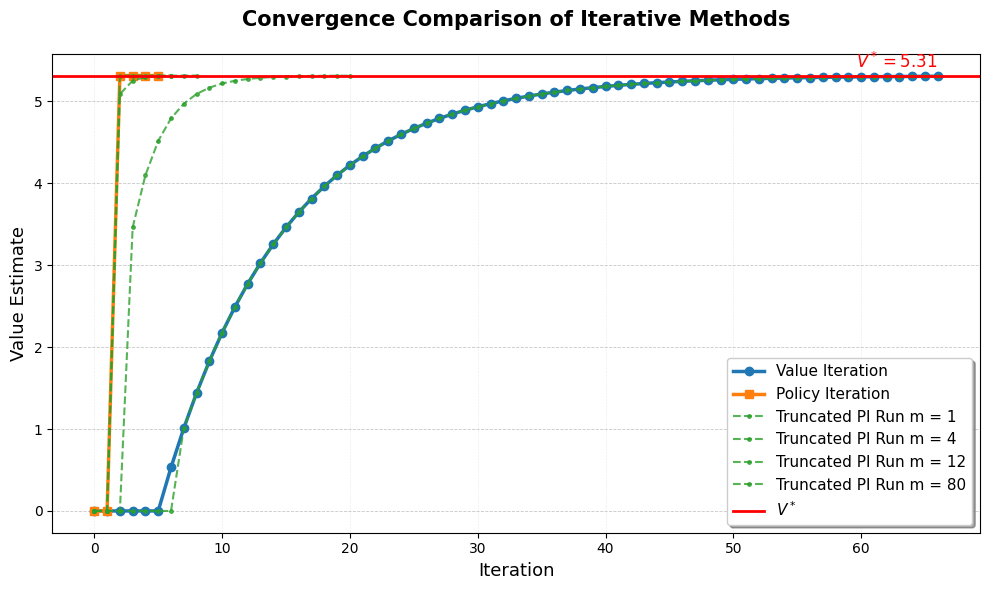

In [74]:

# 基准值 V*
V_star = policy_iteration_s_history[-1]

# === 开始绘图 ===
plt.figure(figsize=(10, 6))

# 使用更柔和的颜色（避免刺眼）
colors = plt.cm.tab10.colors  # 内置优秀配色方案

# 主曲线：加粗 + 圆点标记
plt.plot(value_iteration, 
         label='Value Iteration', 
         color=colors[0], 
         linewidth=2.5, 
         marker='o', 
         markersize=6)

plt.plot(policy_iteration_s_history, 
         label='Policy Iteration', 
         color=colors[1], 
         linewidth=2.5, 
         marker='s', 
         markersize=6)

# 截断策略迭代：虚线 + 浅色 + 小标记
for m, hist in truncated_policy_iteration_histories:
    plt.plot(hist, 
             '--', 
             label=f'Truncated PI Run m = {m}', 
             color=colors[2 + i % (len(colors)-2)], 
             linewidth=1.5, 
             alpha=0.8,
             marker='.', 
             markersize=5)

# 基准线 V*：红色实线 + 加粗 + 标注文字
plt.axhline(y=V_star, 
            color='red', 
            linestyle='-', 
            linewidth=2, 
            label=r'$V^*$')

# 在右侧添加 V* 数值标签（可选）
plt.text(len(value_iteration) - 1, V_star + 0.05, f'$V^* = {V_star:.2f}$',
         color='red', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# === 美化细节 ===
plt.xlabel('Iteration', fontsize=13)
plt.ylabel('Value Estimate', fontsize=13)
plt.title('Convergence Comparison of Iterative Methods', fontsize=15, weight='bold', pad=20)

# 图例放在最佳位置（避免遮挡曲线）
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=11)

# 网格：浅灰色，仅水平线（更清爽）
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
plt.grid(True, which='major', axis='x', linestyle=':', linewidth=0.4, alpha=0.5)

# 边距自动调整
plt.tight_layout()

# 可选：设置背景色为白色（确保导出清晰）
plt.gca().set_facecolor('white')

# 显示图形
plt.show()


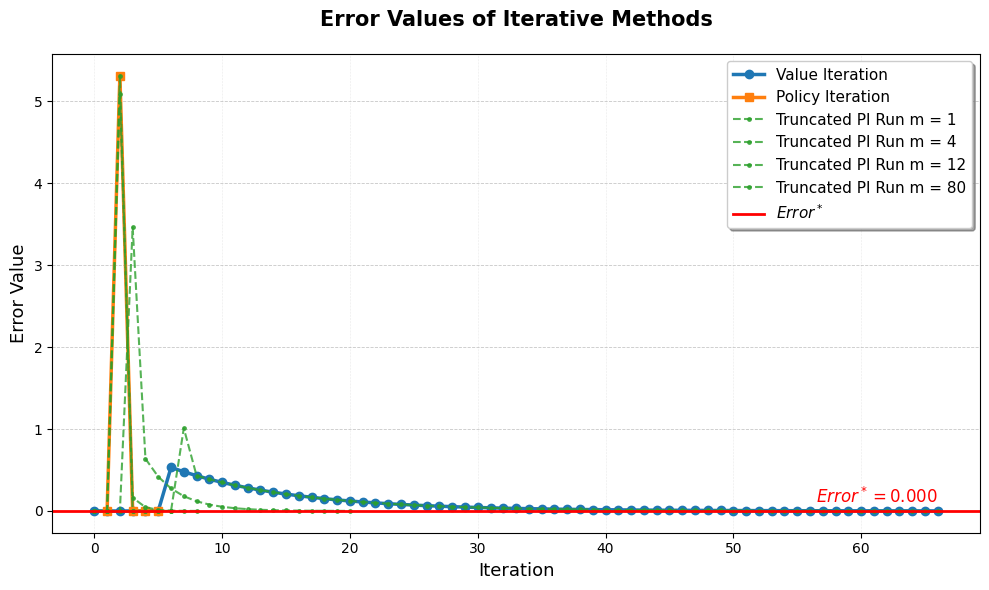

In [83]:

# 基准值 V*
V_star = pehistory[-1]

# === 开始绘图 ===
plt.figure(figsize=(10, 6))

# 使用更柔和的颜色（避免刺眼）
colors = plt.cm.tab10.colors  # 内置优秀配色方案

# 主曲线：加粗 + 圆点标记
plt.plot(vehistory, 
         label='Value Iteration', 
         color=colors[0], 
         linewidth=2.5, 
         marker='o', 
         markersize=6)

plt.plot(pehistory, 
         label='Policy Iteration', 
         color=colors[1], 
         linewidth=2.5, 
         marker='s', 
         markersize=6)

# 截断策略迭代：虚线 + 浅色 + 小标记
for m, hist in tehistories:
    plt.plot(hist, 
             '--', 
             label=f'Truncated PI Run m = {m}', 
             color=colors[2 + i % (len(colors)-2)], 
             linewidth=1.5, 
             alpha=0.8,
             marker='.', 
             markersize=5)

plt.axhline(y=V_star, 
            color='red', 
            linestyle='-', 
            linewidth=2, 
            label=r'$Error^*$')

plt.text(len(value_iteration) - 1, V_star + 0.05, f'$Error^* = {V_star:.3f}$',
         color='red', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# === 美化细节 ===
plt.xlabel('Iteration', fontsize=13)
plt.ylabel('Error Value', fontsize=13)
plt.title('Error Values of Iterative Methods', fontsize=15, weight='bold', pad=20)

# 图例放在最佳位置（避免遮挡曲线）
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=11)

# 网格：浅灰色，仅水平线（更清爽）
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
plt.grid(True, which='major', axis='x', linestyle=':', linewidth=0.4, alpha=0.5)

# 边距自动调整
plt.tight_layout()

# 可选：设置背景色为白色（确保导出清晰）
plt.gca().set_facecolor('white')

# 显示图形
plt.show()
